In [55]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import pandas as pd
import pickle as pkl
import numpy as np
import collections as cx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import PrecisionRecallDisplay

from src.config import PROFILE_TYPE, SAMPLE, TARGET, get_experiment_artifacts, PAIRED_SAMPLES, get_hussmann_supplementary_xlsx

In [57]:
psuedo_controls = pd.read_csv(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/psuedo_controls.txt").rename(columns={"0": "Gene"})["Gene"]
psuedo_controls.shape

(100,)

In [58]:
get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700)

'/Users/colm/repos/MUSICian/notebooks/exploratory/outlier_detection/artifacts/sample.robust_cov.700/'

In [59]:
outlier_details_df = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik  0.340629        -0.250000  -0.420581                -0.362677   
0610010K14Rik -0.339087         0.464286  -0.593305                -0.183878   
0610030E20Rik -0.012887         0.035714  -0.334304                 0.194480   
0610040J01Rik  1.405359         0.107143   0.386962                -0.246977   
1110004F10Rik  1.223375        -0.178571   0.208164                -0.115229   
...                 ...              ...        ...                      ...   
Znhit1         0.550000         0.160714   0.225832                 0.962391   
Zranb2         1.278388         0.071429   0.495311                 0.745030   
Zrsr1          1.347381        -0.125000   0.240567                -1.200930   
Zup1           0.948928        -0.142857   0.206600                -0.312950   
Zwilch         1.850794         0.125000   0.324977                -0.603581   

Sample                                MB01                        MB02  \
Measure       Mean Std Consistency  Counts distances   pvalues  Counts   
Gene                                                                     
0610009B22Rik            -0.875111  2792.0  2.208519  0.819605  3122.0   
0610010K14Rik             0.856053  2320.5  1.027360  0.960329  2451.0   
0610030E20Rik            -0.151019  1638.0  9.058759  0.106743  2770.0   
0610040J01Rik             0.003445  1753.0  8.903629  0.112970  1798.0   
1110004F10Rik            -0.669054  1876.0  9.464008  0.091927  1929.0   
...                            ...     ...       ...       ...     ...   
Znhit1                    0.149099  1347.0       NaN       NaN     NaN   
Zranb2                   -0.070255     NaN       NaN       NaN  1180.0   
Zrsr1                    -0.521981     NaN       NaN       NaN  1339.5   
Zup1                     -0.567696  1292.5       NaN       NaN     NaN   
Zwilch                    0.059764     NaN       NaN       NaN     NaN   

Sample                    ...          T1              T2              \
Measure        distances  ... Consistency CLR Consistency Consistency   
Gene                      ...                                           
0610009B22Rik   2.124921  ...   -0.821429        0.392857    0.500000   
0610010K14Rik   0.854783  ...    0.678571       -0.321429    0.071429   
0610030E20Rik   4.471164  ...    0.464286        0.214286    0.071429   
0610040J01Rik  16.242836  ...    0.250000       -0.321429   -0.071429   
1110004F10Rik  17.195650  ...    0.107143       -0.071429   -0.214286   
...                  ...  ...         ...             ...         ...   
Znhit1               NaN  ...         NaN        0.714286    0.821429   
Zranb2               NaN  ...         NaN        0.321429   -0.178571   
Zrsr1                NaN  ...         NaN       -0.428571    0.250000   
Zup1                 NaN  ...         NaN       -0.107143   -0.107143   
Zwilch               NaN  ...         NaN        0.071429    0.285714   

Sample                     T3             Gene Sets              \
Measure       CLR Consistency Consistency   Adamson GeneSubset2   
Gene                                                              
0610009B22Rik        0.250000   -0.428571     False       False   
0610010K14Rik       -0.357143    0.642857     False       False   
0610030E20Rik        0.000000   -0.428571     False       False   
0610040J01Rik        0.285714    0.142857     False       False   
1110004F10Rik       -0.142857   -0.428571     False       False   
...                       ...         ...       ...         ...   
Znhit1               0.250000   -0.500000      True       False   
Zranb2               0.464286    0.321429     False       False   
Zrsr1               -0.428571   -0.500000     False       False   
Zup1           

In [60]:
X_imputed = pkl.load(open(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/imputed_sample_data.pkl", "rb"))

print("Data Ready.")

Data Ready.


In [61]:
df = pd.concat(X_imputed.values(), keys=X_imputed.keys(), names=["Sample"])
print(df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample").apply(stats.gmean).values.tolist(), index=X_imputed.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = df - psudo_control_gmean_df
change_df
print(change_df.shape)

(104800, 7)
(6, 7)
(104800, 7)


Index(['Gene', 'lumc_category', 'MB03', 'MB04'], dtype='object', name='Sample')


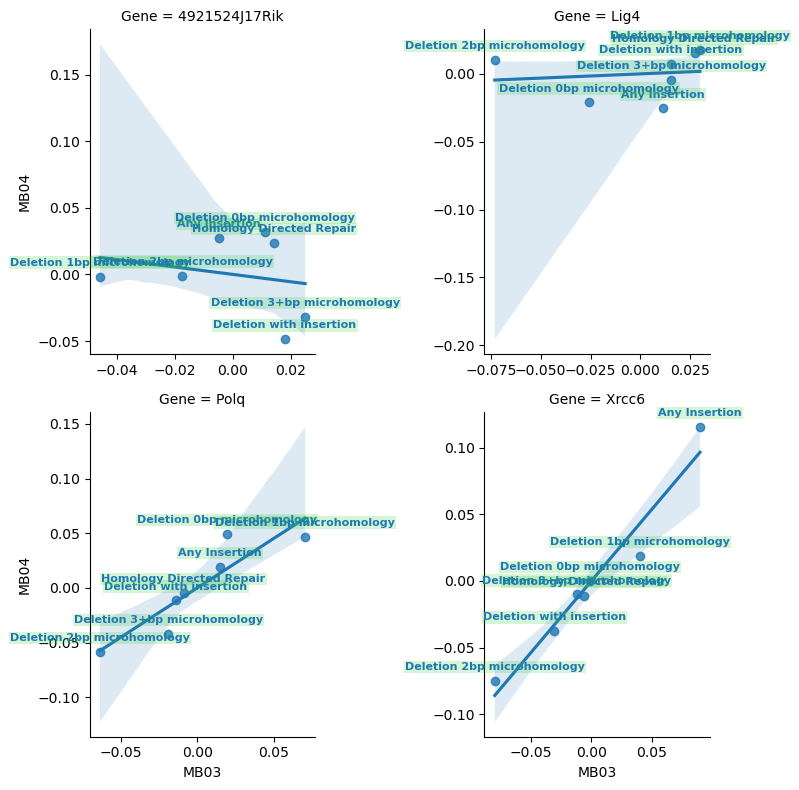

In [62]:
plot_df = change_df.loc[["MB03", "MB04"]].stack().reset_index().pivot(index=["Gene", "lumc_category"], columns="Sample", values=0).reset_index()
plot_df = plot_df[plot_df["Gene"].isin(["4921524J17Rik", "Polq", "Lig4", "Xrcc6"])]
print(plot_df.columns)
g = sns.FacetGrid(data=plot_df, col="Gene", col_wrap=2, height=4, aspect=1, sharex=False, sharey=False)
# g.map_dataframe(sns.regplot, x="MB03", y="MB04")

def f(x, y, z,**kwargs):
    ax = sns.regplot(x=x,y=y,**kwargs)
    data = kwargs["data"]
    l = data[x].shape[0]
    for i in range(l):
        ax.annotate(str(data[z].iloc[i]), xy=(data[x].iloc[i], data[y].iloc[i]), fontsize=8,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9,alpha=0.2, fc='limegreen',color='none'),
                va='center', ha='center',weight='bold')

g.map_dataframe(f, x="MB03", y="MB04", z="lumc_category")


# Comparison of consistencies between methods

In [63]:
outlier_details_df_pca_replicate_700 = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="pca", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df_robust_cov_replicate_700 = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df_robust_cov_paired_700 = pd.read_pickle(get_experiment_artifacts(profile_type=PAIRED_SAMPLES, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")


In [64]:
comparison_df = pd.concat({
    # "PCA (700)" : outlier_details_df_pca_replicate_700.sort_values(("Global", "Mean Score"), ascending=False),
    "Replicate (700)" : outlier_details_df_robust_cov_replicate_700.sort_values(("Global", "Mean Score"), ascending=False),
    "Paired Replicate (700)" : outlier_details_df_robust_cov_paired_700.sort_values(("Global", "Mean Score"), ascending=False)
}, names = ["Method"]).xs("Consistency", level="Measure", axis=1)


comparison_df_500 = pd.concat({
    # "PCA (700)" : outlier_details_df_pca_replicate_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,],
    "Replicate (700)" : outlier_details_df_robust_cov_replicate_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,],
    "Paired Replicate (700)" : outlier_details_df_robust_cov_paired_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,]
}, names = ["Method"]).xs("Consistency", level="Measure", axis=1)

comparison_df_1000 = pd.concat({
    # "PCA (700)" : outlier_details_df_pca_replicate_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:1000,],
    "Replicate (700)" : outlier_details_df_robust_cov_replicate_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:1000,],
    "Paired Replicate (700)" : outlier_details_df_robust_cov_paired_700.sort_values(("Global", "Mean Score"), ascending=False).iloc[:1000,]
}, names = ["Method"]).xs("Consistency", level="Measure", axis=1)



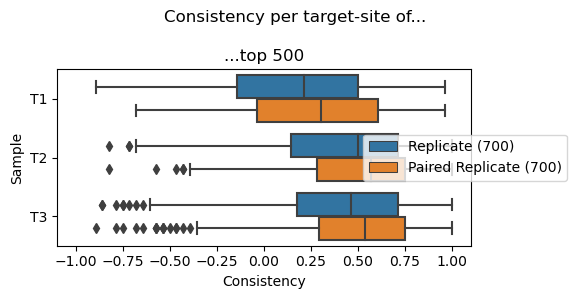

In [65]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

# g = sns.boxplot(data = comparison_df_1000.stack().dropna().reset_index().rename(columns={0: "Consistency"}), x = "Consistency", y = "Sample", hue = "Method", ax=ax1, order=["T1", "T2", "T3"])
# ax1.title.set_text("...top 1000")
# ax1.set_xlim([-1.1, 1.1])

sns.boxplot(data = comparison_df_500.stack().dropna().reset_index().rename(columns={0: "Consistency"}), x = "Consistency", y = "Sample", hue = "Method", ax=ax1, order=["T1", "T2", "T3"])
# ax1.legend([],[], frameon=False)
ax1.title.set_text("...top 500")
ax1.set_xlim([-1.1, 1.1])
plt.suptitle("Consistency per target-site of...")

# pos = ax1.get_position()
# ax1.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

plt.tight_layout()
fig.savefig(get_experiment_artifacts() + "consistencycomparison.pdf")

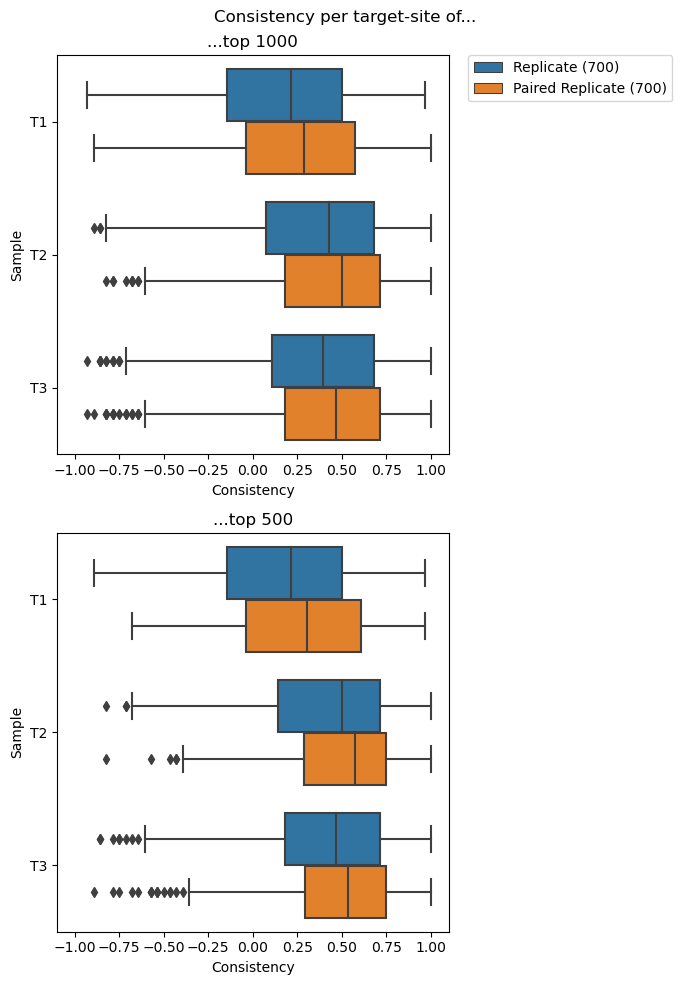

In [66]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(7, 10))

g = sns.boxplot(data = comparison_df_1000.stack().dropna().reset_index().rename(columns={0: "Consistency"}), x = "Consistency", y = "Sample", hue = "Method", ax=ax1, order=["T1", "T2", "T3"])
ax1.title.set_text("...top 1000")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlim([-1.1, 1.1])

sns.boxplot(data = comparison_df_500.stack().dropna().reset_index().rename(columns={0: "Consistency"}), x = "Consistency", y = "Sample", hue = "Method", ax=ax2, order=["T1", "T2", "T3"])
ax2.legend([],[], frameon=False)
ax2.title.set_text("...top 500")
ax2.set_xlim([-1.1, 1.1])
plt.suptitle("Consistency per target-site of...")
plt.tight_layout()

fig.savefig(get_experiment_artifacts() + "consistencycomparison.pdf")


In [67]:
from scipy.stats import mannwhitneyu
# pvalues with scipy:
stat_results = [
  mannwhitneyu(comparison_df_500.loc["Replicate (700)", "T1"].dropna(), comparison_df_500.loc["Paired Replicate (700)", "T1"].dropna(), alternative="less"),
  mannwhitneyu(comparison_df_500.loc["Replicate (700)", "T2"].dropna(), comparison_df_500.loc["Paired Replicate (700)", "T2"].dropna(), alternative="less"),
  mannwhitneyu(comparison_df_500.loc["Replicate (700)", "T3"].dropna(), comparison_df_500.loc["Paired Replicate (700)", "T3"].dropna(), alternative="less"),
]
stat_results

[MannwhitneyuResult(statistic=22315.0, pvalue=0.004632340660916254),
 MannwhitneyuResult(statistic=103193.0, pvalue=0.0013439774227429595),
 MannwhitneyuResult(statistic=108367.5, pvalue=0.001371354283837831)]

In [68]:
stat_results = [
  mannwhitneyu(comparison_df_1000.loc["Replicate (700)", "T1"].dropna(), comparison_df_1000.loc["Paired Replicate (700)", "T1"].dropna(), alternative="less"),
  mannwhitneyu(comparison_df_1000.loc["Replicate (700)", "T2"].dropna(), comparison_df_1000.loc["Paired Replicate (700)", "T2"].dropna(), alternative="less"),
  mannwhitneyu(comparison_df_1000.loc["Replicate (700)", "T3"].dropna(), comparison_df_1000.loc["Paired Replicate (700)", "T3"].dropna(), alternative="less"),
]
stat_results

[MannwhitneyuResult(statistic=128752.5, pvalue=0.0005227334639844966),
 MannwhitneyuResult(statistic=428908.5, pvalue=0.0021808730136076396),
 MannwhitneyuResult(statistic=446848.0, pvalue=0.0021962931719639043)]

In [69]:
from sklearn import metrics

def plot_curves(outliers_df_rep, outliers_df_paired, genes, name=None, title1=None, title2=None, limit=None, filename=None):
    if limit is None:
        l = outliers_df_rep.shape[0]
    else:
        l = limit

    all_y = np.isin(outliers_df_rep.sample(frac=1).index.to_list(), genes)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    y = all_y[-l:]
    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y)))[::-1],
        name=f"PR Curve",
        color="darkorange",
        ax=ax1
    )
    ax1.title.set_text("Randomly")
    
    y = np.isin(outliers_df_rep.sort_values(("Global", "Mean Std Consistency")).index.to_list(), genes)[-l:]
    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y))),
        name=f"PR Curve",
        color="darkorange",
        ax=ax2
    )
    ax2.title.set_text("By Consistency")

    if limit is not None:
        ax2.title.set_text(ax2.title.get_text() + " Positives: {}/{}".format(sum(y), sum(all_y)))

    y = np.isin(outliers_df_rep.sort_values(("Global", "Mean Score")).index.to_list(), genes)[-l:]
    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y))),
        name=f"PR Curve",
        color="darkorange",
        ax=ax3
    )
    ax3.title.set_text("By Ranked Single-Replicate Profiles" if title1 is None else title1)
    
    if limit is not None:
        ax3.title.set_text(ax3.title.get_text() + " Positives: {}/{}".format(sum(y), sum(all_y)))
    
    y = np.isin(outliers_df_paired.sort_values(("Global", "Mean Score")).index.to_list(), genes)[-l:]
    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y))),
        name=f"PR Curve",
        color="darkorange",
        ax=ax4
    )
    ax4.title.set_text("By Ranked Paired-Replicate Profiles" if title2 is None else title2)
    
    if limit is not None:
        ax4.title.set_text(ax4.title.get_text() + " Positives: {}/{}".format(sum(y), sum(all_y)))

    if limit is None:
        fig.suptitle("PR Curve ({}, {} positive labels), ranked...".format(name, sum(all_y)))
    else:
        fig.suptitle("PR Curve of top {} genes, ranked...".format(limit))
    plt.tight_layout()
    fig.savefig(get_experiment_artifacts() + "rankingcomparison.{}.{}.pdf".format(name, "replicate_vs_paired" if filename is None else filename))
    plt.show()

In [70]:
outlier_details_df_pca_replicate_700 = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="pca", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df_robust_cov_paired_700 = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")

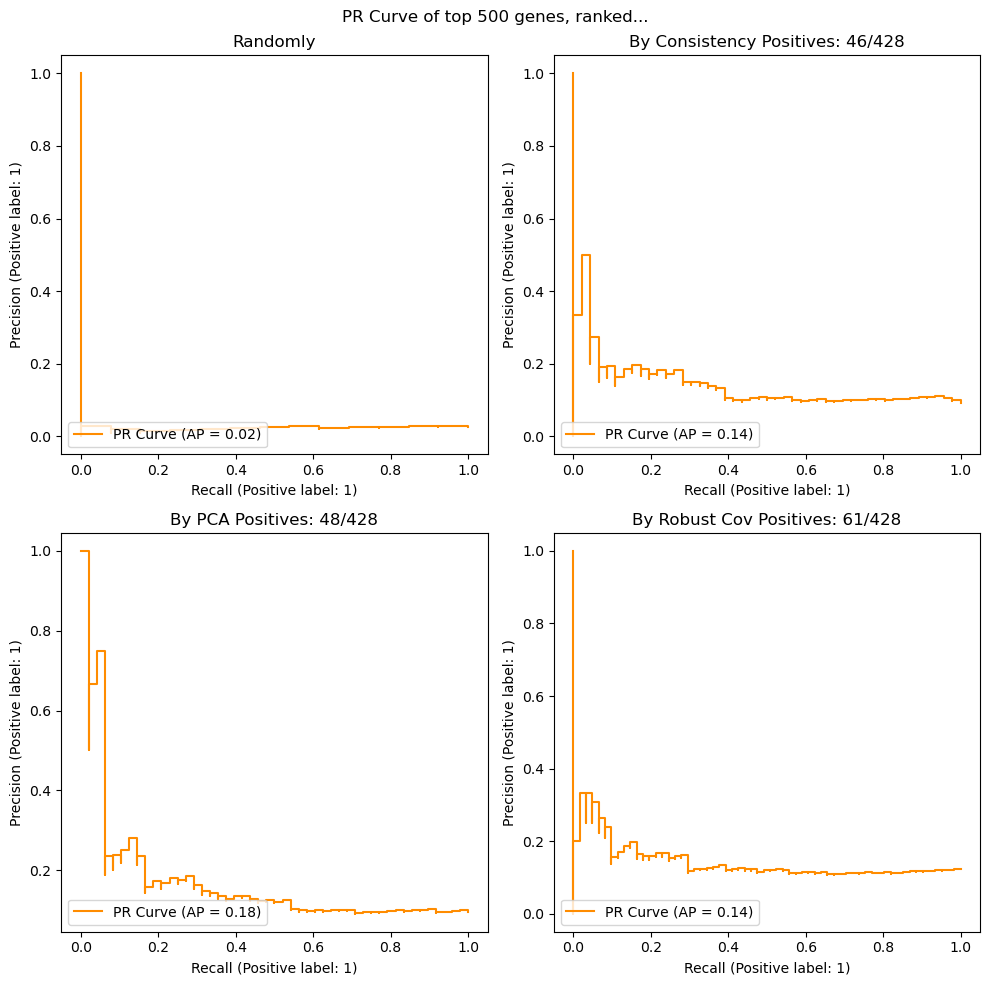

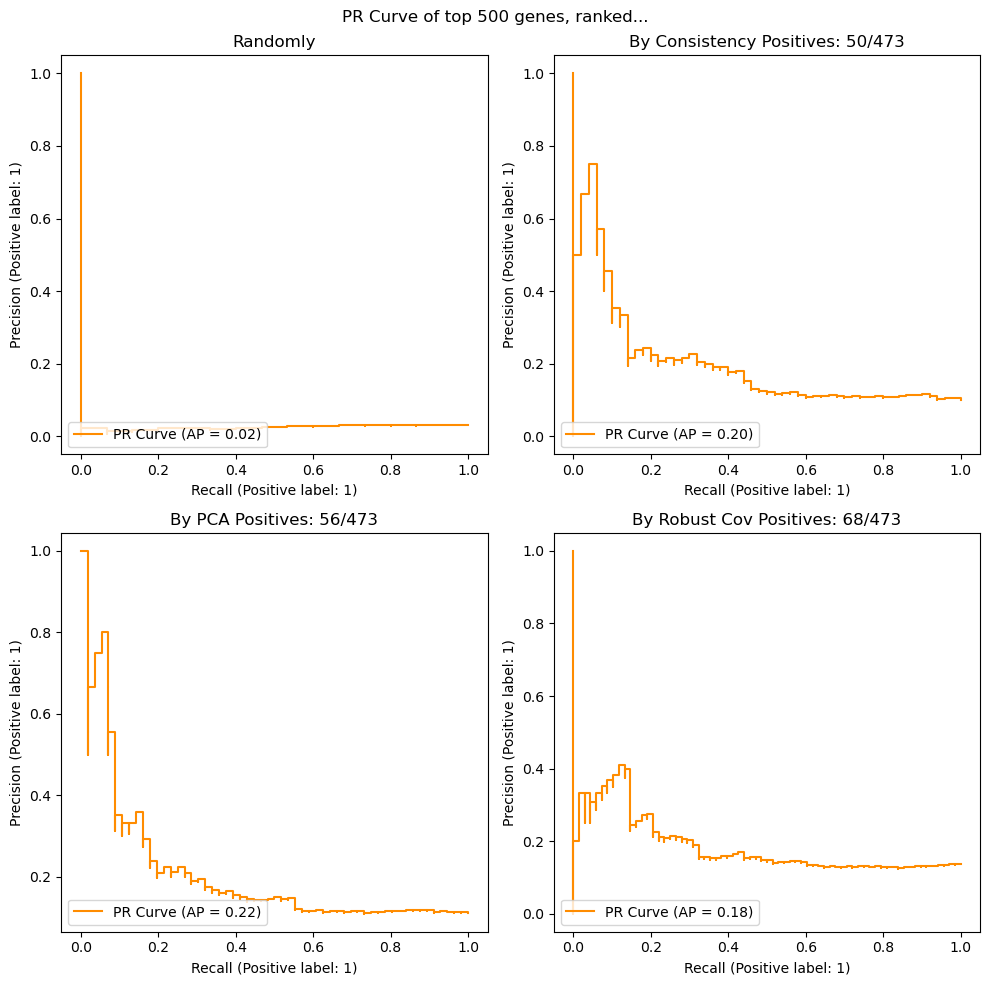

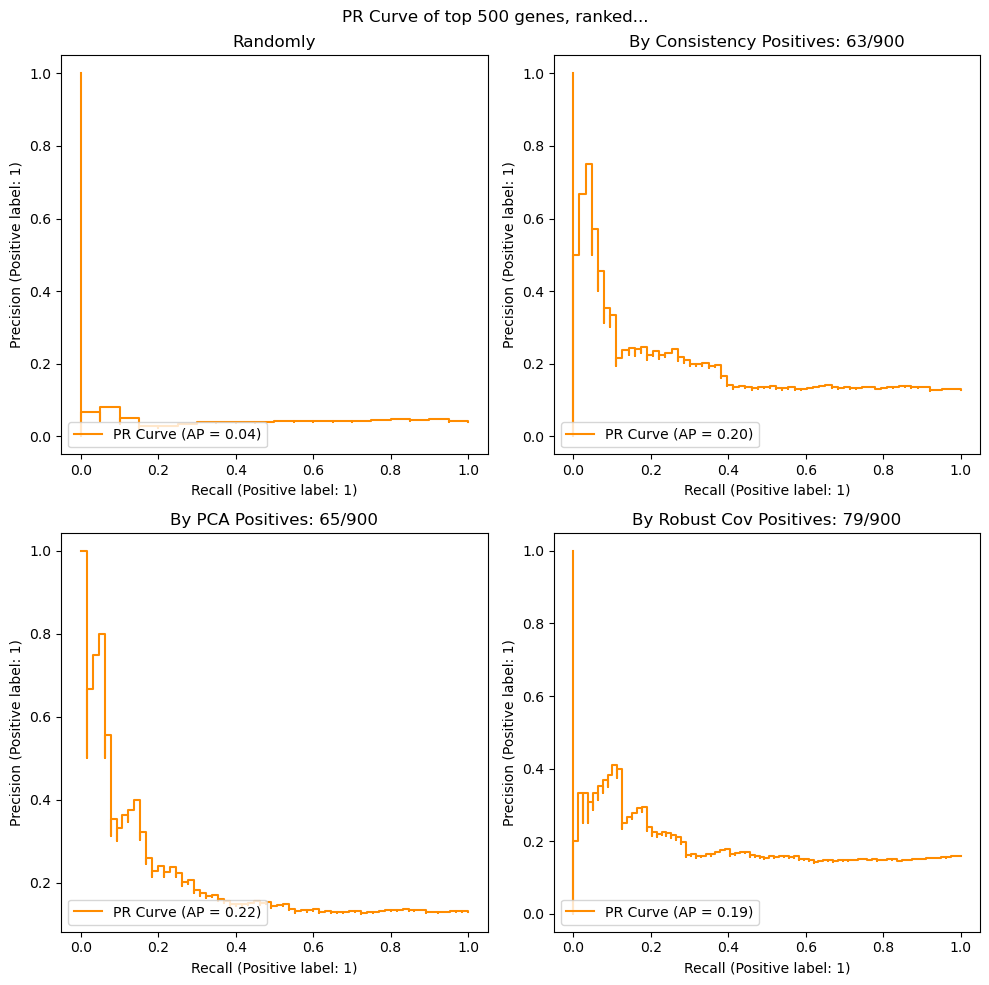

In [71]:
adamson_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.capitalize()
plot_curves(outlier_details_df_pca_replicate_700, outlier_details_df_robust_cov_paired_700, adamson_genes, name="Adamson", title1="By PCA", title2="By Robust Cov", limit=500, filename="pca_vs_robust")

GODSBRepair = outlier_details_df_pca_replicate_700.loc[outlier_details_df_pca_replicate_700[("Global", "isGODSBRepair")]].index.to_list()
plot_curves(outlier_details_df_pca_replicate_700, outlier_details_df_robust_cov_paired_700, GODSBRepair, name="GO_DSB_Repair", title1="By PCA", title2="By Robust Cov", limit=500, filename="pca_vs_robust")

GORepair = outlier_details_df_pca_replicate_700.loc[outlier_details_df_pca_replicate_700[("Global", "isGORepair")]].index.to_list()
plot_curves(outlier_details_df_pca_replicate_700, outlier_details_df_robust_cov_paired_700, GORepair, name="GO_Repair", title1="By PCA", title2="By Robust Cov", limit=500, filename="pca_vs_robust")

In [72]:
outlier_details_df_robust_cov_replicate_700 = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df_robust_cov_paired_700 = pd.read_pickle(get_experiment_artifacts(profile_type=PAIRED_SAMPLES, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")

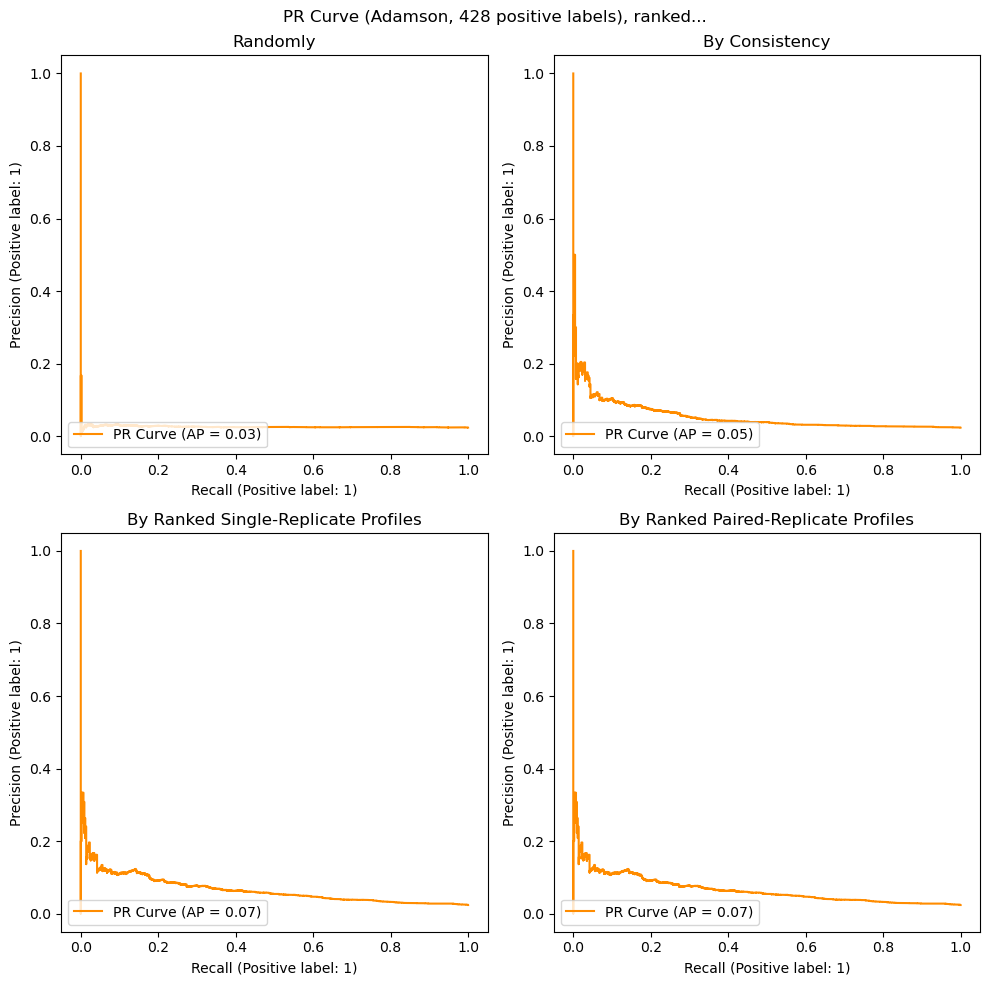

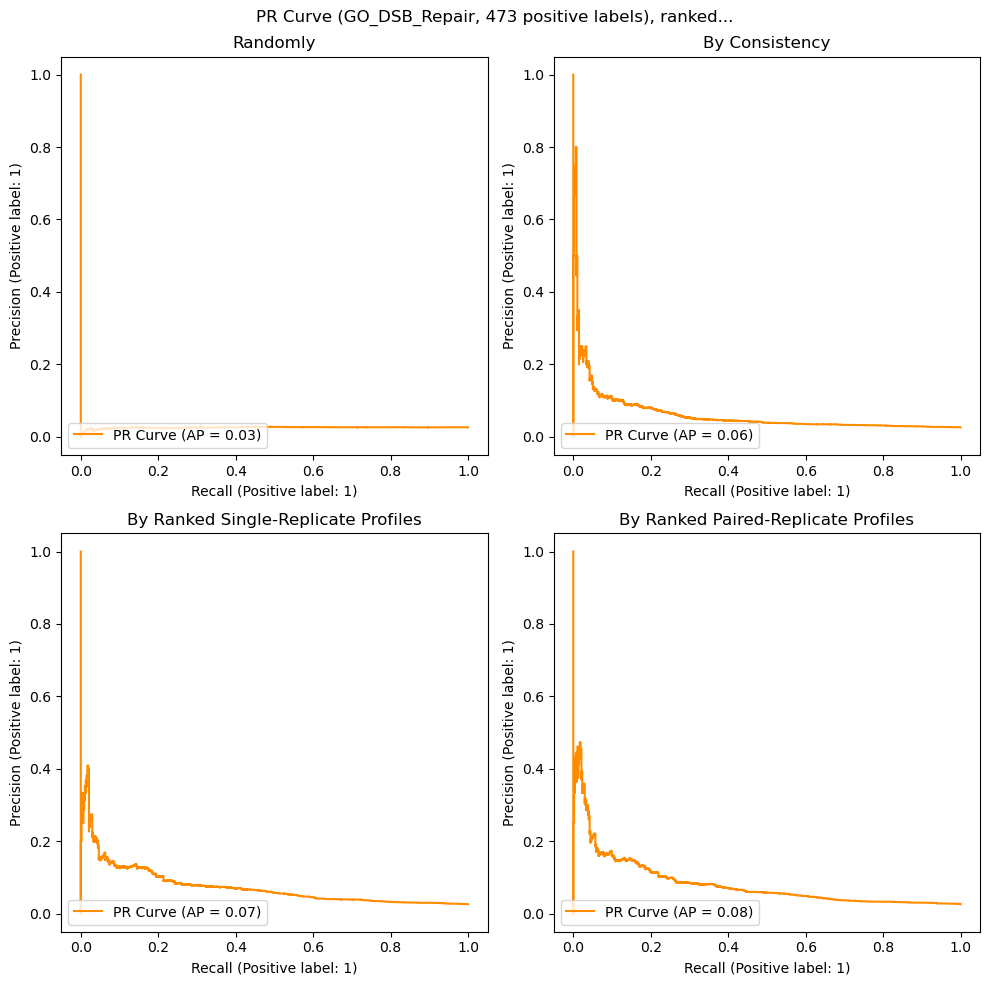

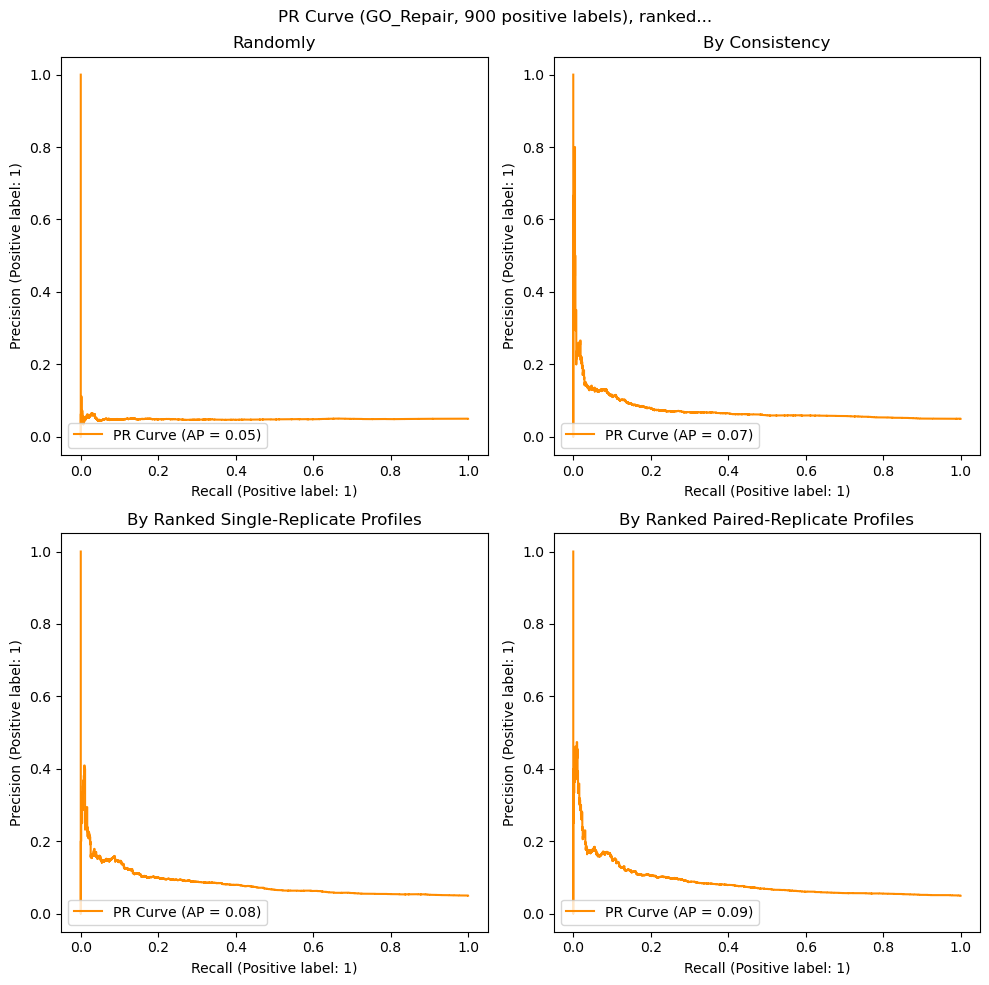

In [73]:
adamson_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.capitalize()
plot_curves(outlier_details_df_robust_cov_replicate_700, outlier_details_df_robust_cov_replicate_700, adamson_genes, name="Adamson")

GODSBRepair = outlier_details_df_robust_cov_replicate_700.loc[outlier_details_df_robust_cov_replicate_700[("Global", "isGODSBRepair")]].index.to_list()
plot_curves(outlier_details_df_robust_cov_replicate_700, outlier_details_df_robust_cov_paired_700, GODSBRepair, name="GO_DSB_Repair")

GORepair = outlier_details_df_robust_cov_replicate_700.loc[outlier_details_df_robust_cov_replicate_700[("Global", "isGORepair")]].index.to_list()
plot_curves(outlier_details_df_robust_cov_replicate_700, outlier_details_df_robust_cov_paired_700, GORepair, name="GO_Repair")

In [74]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

_d = outlier_details_df_pca_replicate_700[[("Global", "Mean Std Consistency"), ("Global", "Mean Score")]].droplevel(axis=1, level=0)
print(_d[["Mean Score"]].min())
y = _d["Mean Std Consistency"]
X = _d[["Mean Score"]]
model.fit(X, y)
print(model.intercept_, model.coef_, model.score(X, y))

Measure
Mean Score   -0.841556
dtype: float64
-0.009857909076985841 [0.12210608] 0.0451946155067835


In [75]:
_d = outlier_details_df_robust_cov_replicate_700[[("Global", "Mean Std Consistency"), ("Global", "Mean Score")]].droplevel(axis=1, level=0).dropna()
print(_d[["Mean Score"]].min())
y = _d["Mean Std Consistency"]
X = _d[["Mean Score"]]
model.fit(X, y)
print(model.intercept_, model.coef_, model.score(X, y))

Measure
Mean Score   -0.753477
dtype: float64
-0.008398502067836343 [0.10449509] 0.04575265304891707


In [76]:
_d = outlier_details_df_robust_cov_paired_700[[("Global", "Mean Std Consistency"), ("Global", "Mean Score")]].droplevel(axis=1, level=0).dropna()
y = _d["Mean Std Consistency"]
X = _d[["Mean Score"]]
model.fit(X, y)
print(model.intercept_, model.coef_, model.score(X, y))

-0.01736189195329061 [0.14844544] 0.10863282186684464


In [113]:
_d = outlier_details_df_robust_cov_replicate_700[[("Global", "Mean Std Consistency"), ("Global", "Mean Score"), ("Global", "isGODSBRepair")]].droplevel(axis=1, level=0).dropna()
top_consistent_genes = _d.sort_values(by=("Mean Std Consistency"), ascending=False)[:500]
top_scoring_genes = _d.sort_values(by=("Mean Score"), ascending=False)[:500]

top_consistent_genes = top_consistent_genes.index[top_consistent_genes["isGODSBRepair"]]
top_scoring_genes = top_scoring_genes.index[top_scoring_genes["isGODSBRepair"]]

jaccard_sim = len(np.intersect1d(top_consistent_genes, top_scoring_genes))/len(np.union1d(top_consistent_genes, top_scoring_genes))
jaccard_sim


0.29347826086956524